# Tutorial on How to Run Measurement Inference (Prior to the Gate Measurements)

In [1]:
import os
if not os.path.exists('error_data'):
    os.makedirs('error_data')

In [2]:
import numpy as np
import pandas as pd

# read_csv usually handles types smarter, but best to be explicit
df = pd.read_csv('error_data/State0.csv', header=None, dtype=str)
data_zeros = df.values.flatten()

df = pd.read_csv('error_data/State1.csv', header=None, dtype=str)
data_ones = df.values.flatten()

## Inference

It is important to have 2 datasets, each with the dominant error being the measurement error at the very end. One set of data, as above, should be theoretically all zeros, any deviations are caused by the final error in measurement when there is a bitflip error from $0 \rightarrow 1$. The other is to be theoretically all ones, and the deviations are also caused by a final measurement error, this time a separate error rate, the rate of bitflips when measurement flips $1 \rightarrow 0$.

Loaded 590 Posterior Values for Qubit 1, State 0.
Loaded 491 Posterior Values for Qubit 0, State 0.
Loaded 827 Posterior Values for Qubit 1, State 1.
Loaded 742 Posterior Values for Qubit 0, State 1.
Loaded 262144 shots for State 0.
Loaded 262144 shots for State 1.

--- Starting Calibration ---
Calibrating |0> state...
   Debug: Using 262144 shots split into 32 points for KDE.
Inferring Qubit 1 for State |0>
Given Lambda |0>: success rate = 0.9965


/Users/chardiol/Desktop/Pawsey!/UnNoiseCompile/.venv/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


<Figure size 640x480 with 0 Axes>

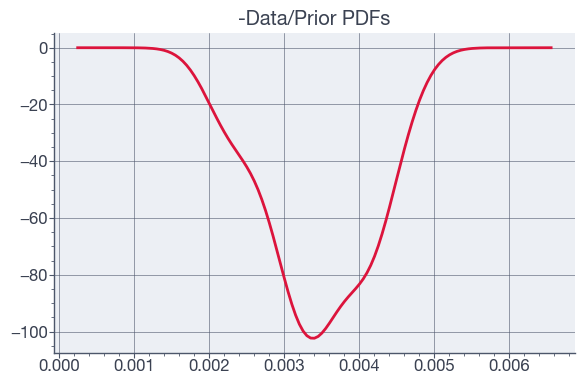

In [ ]:
from src.splitmeasfilter import SplitMeasFilter  # Assuming class is saved here

# Initialize
# Qubit order must match your bitstrings (e.g., '01' -> q1=0, q0=1 or vice versa depending on endianness)
# Standard Qiskit/Braket is usually Little Endian (Rightmost is q0)
qubits = [1, 0] 
my_filter = SplitMeasFilter(qubit_order=qubits, file_address='error_data/')

print("\n--- Starting Calibration ---")

## providing the true errors which I used to simulate the data in samples/CZ_test.ipynb
my_filter.params = {
    0: {'pm1p0': 0.0027, 'pm0p1': 0.0072},  # Qubit 0: Expect 1% error on 0, 2% error on 1
    1: {'pm1p0': 0.0035, 'pm0p1': 0.0085}   # Qubit 1: Expect 5% error (Standard/Noisy)
}

# Pass 1: Calibrate Error on State |0>
print("Calibrating |0> state...")
my_filter.inference(prep_state='0', nPrior=40000, prior_sd= 0.1, shots_per_point = 8192)

# Pass 2: Calibrate Error on State |1>
print("Calibrating |1> state...")
my_filter.inference(prep_state='1', nPrior=40000, prior_sd= 0.1, shots_per_point = 8192)

print("Inference Complete.")


--- Error Analysis ---


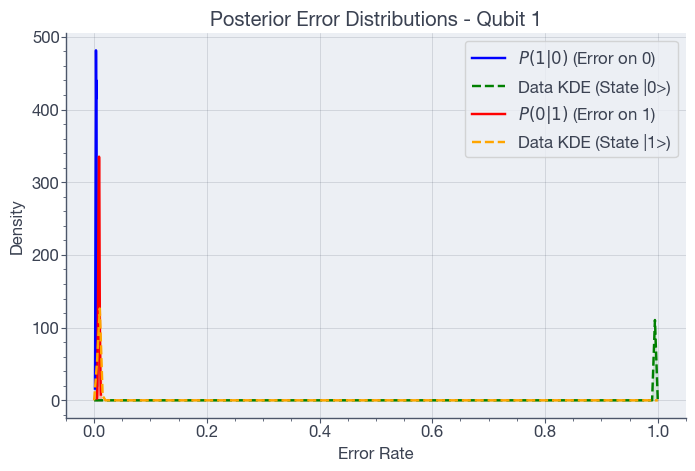

--- Qubit 1 Summary ---
Error on |0>: 0.0034 (95% CI: 0.0020 - 0.0047)
Error on |1>: 0.0085 (95% CI: 0.0062 - 0.0109)
------------------------------


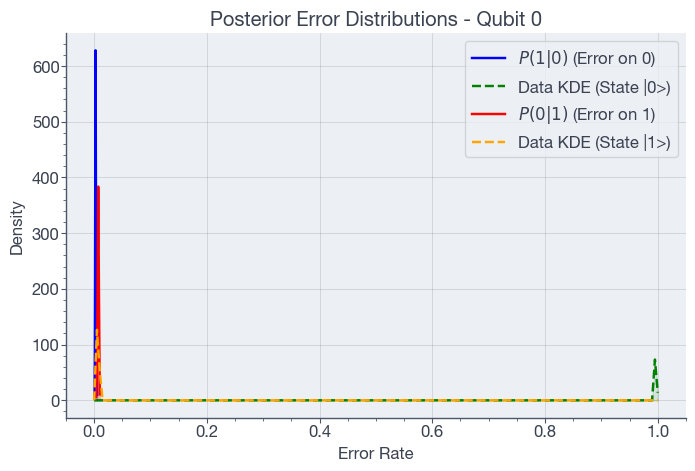

--- Qubit 0 Summary ---
Error on |0>: 0.0026 (95% CI: 0.0014 - 0.0046)
Error on |1>: 0.0072 (95% CI: 0.0047 - 0.0093)
------------------------------


In [ ]:
# ---------------------------------------------------------
# ANALYZE RESULTS
# ---------------------------------------------------------
print("\n--- Error Analysis ---")
# This will pop up the plots and print the error %
stats = my_filter.error_distributions(plotting=True, save_plots= True)